<a href="https://colab.research.google.com/github/sanghee0627/-/blob/main/%EC%88%98%EC%A0%95%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim


from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/fox.zip 파일 선택

In [2]:
!unzip fox.zip -d fox/

Archive:  fox.zip
   creating: fox/fox/
  inflating: fox/fox/.DS_Store       
  inflating: fox/__MACOSX/fox/._.DS_Store  
   creating: fox/fox/test/
   creating: fox/fox/train/
   creating: fox/fox/test/붉은여우/
  inflating: fox/fox/test/.DS_Store  
  inflating: fox/__MACOSX/fox/test/._.DS_Store  
   creating: fox/fox/test/북극여우/
   creating: fox/fox/train/붉은여우/
  inflating: fox/fox/train/.DS_Store  
  inflating: fox/__MACOSX/fox/train/._.DS_Store  
   creating: fox/fox/train/북극여우/
  inflating: fox/fox/test/붉은여우/1080.jpeg  
  inflating: fox/__MACOSX/fox/test/붉은여우/._1080.jpeg  
  inflating: fox/fox/test/붉은여우/1096.jpeg  
  inflating: fox/__MACOSX/fox/test/붉은여우/._1096.jpeg  
  inflating: fox/fox/test/붉은여우/1079.jpeg  
  inflating: fox/__MACOSX/fox/test/붉은여우/._1079.jpeg  
  inflating: fox/fox/test/붉은여우/071859b6aefc21736c70894f9cf5bdf3.jpeg  
  inflating: fox/__MACOSX/fox/test/붉은여우/._071859b6aefc21736c70894f9cf5bdf3.jpeg  
 

In [3]:
data_path = 'fox/fox/train'

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), #이미지 뒤집기
    transforms.RandomRotation(10),  # 10범위로 랜덤회전(이미지 회전)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #적절한 평균 및 표준 편차를 사용한 정규화
])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

119


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
test_path = 'fox/fox/test/'

transform = transforms.Compose(
                [
                   transforms.Resize([256, 256]),
                   transforms.RandomResizedCrop(224),
                   transforms.RandomHorizontalFlip(), #이미지 뒤집기
                   transforms.RandomRotation(10),  # 10범위로 랜덤회전(이미지 회전)
                   transforms.ToTensor(),
                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #적절한 평균 및 표준 편차를 사용한 정규화
                ]
                )

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,#배치조정
    num_workers=8,
    shuffle=True
)

print(len(test_dataset))

69


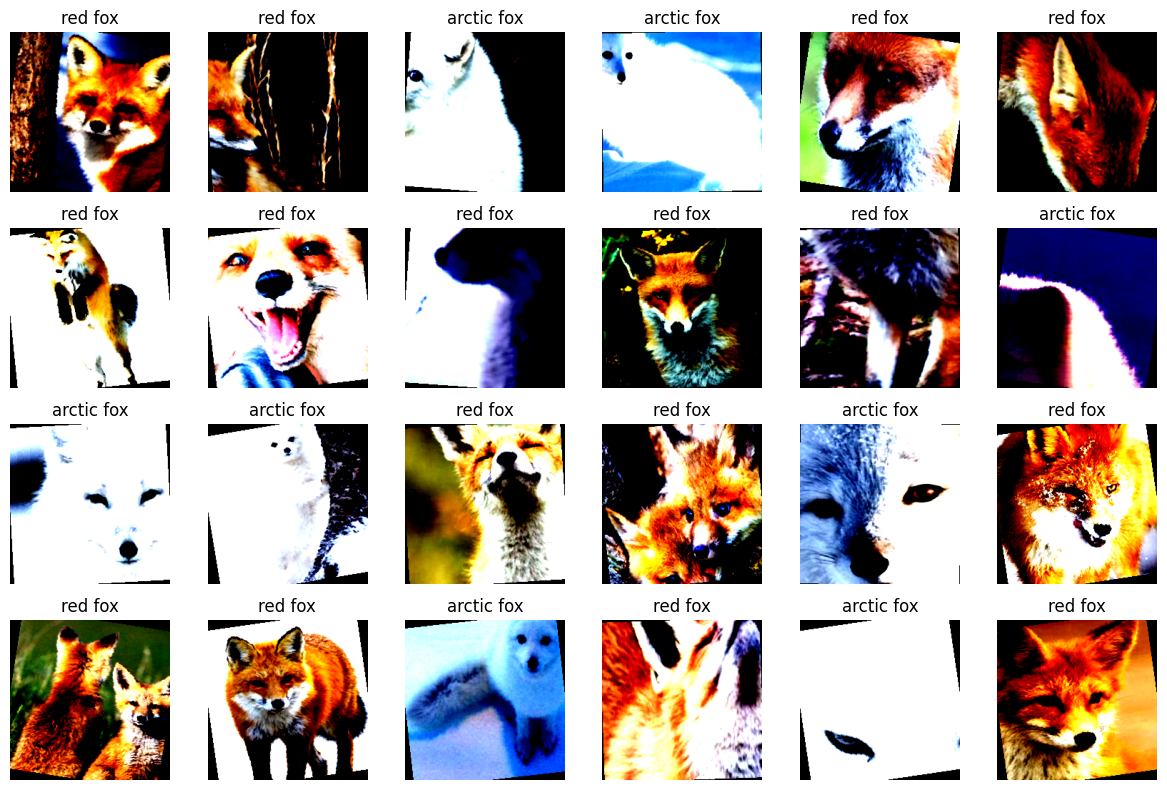

In [5]:
samples, labels = next(iter(train_loader))
classes = {0:'arctic fox', 1:'red fox'}

fig, axes = plt.subplots(4, 6, figsize=(12, 8))

for i, axus in enumerate(axes.flatten()):
    image = np.transpose(samples[i].numpy(), (1, 2, 0))
    label = classes[labels[i].item()]

    axus.imshow(image)
    axus.set_title(label)
    axus.axis('off')

plt.tight_layout()
plt.show()

In [6]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

learning_rate = 0.001;#학습률조정
num_classes = 2  # Modify this according to your dataset
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
print(resnet18)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Learning rate scheduler

print(resnet18)

dataloaders = {
    'train': train_loader,
    'eval' : test_loader
}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=5):
    since = time.time()
    best_acc = 0.0
    acc_history = []
    loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(dataloaders['train'].dataset)
        val_acc = val_corrects.double() / len(dataloaders['train'].dataset)

        print('Val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))

        if val_acc > best_acc:
            best_acc = val_acc

        acc_history.append(val_acc.item())
        loss_history.append(val_loss)

        scheduler.step()  # Update the learning rate
        
    return acc_history, loss_history

In [8]:
def eval_model(model, dataloader, device):
    since = time.time()
    eval_acc_history = []
    eval_loss_history = []
    best_acc = 0.0

    saved_models = glob.glob('fox/fox/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0
        running_loss = 0.0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                 outputs = model(inputs)
                 loss = criterion(outputs, labels)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            running_loss += loss.item() * inputs.size(0)

        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        epoch_loss = running_loss / len(dataloader.dataset)
        print('Acc: {:.4f} Loss: {:.4f}'.format(epoch_acc, epoch_loss))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        eval_acc_history.append(epoch_acc.item())
        eval_loss_history.append(epoch_loss)

    return eval_acc_history, eval_loss_history


In [9]:
acc_history, loss_history = train_model(resnet18, dataloaders, criterion, optimizer, scheduler, device, num_epochs=10)
eval_acc_history, eval_loss_history = eval_model(resnet18, test_loader, device)

Epoch 0/9
----------
Train Loss: 0.6849 Acc: 0.5630
Val Loss: 0.6013 Acc: 0.5798
Epoch 1/9
----------
Train Loss: 0.5482 Acc: 0.7059
Val Loss: 0.4131 Acc: 0.8992
Epoch 2/9
----------
Train Loss: 0.4200 Acc: 0.8908
Val Loss: 0.3219 Acc: 0.9580
Epoch 3/9
----------
Train Loss: 0.3633 Acc: 0.9244
Val Loss: 0.2928 Acc: 0.9664
Epoch 4/9
----------
Train Loss: 0.3823 Acc: 0.8739
Val Loss: 0.2995 Acc: 0.9496
Epoch 5/9
----------
Train Loss: 0.3273 Acc: 0.9412
Val Loss: 0.3141 Acc: 0.9412
Epoch 6/9
----------
Train Loss: 0.3205 Acc: 0.9412
Val Loss: 0.3322 Acc: 0.9580
Epoch 7/9
----------
Train Loss: 0.3105 Acc: 0.9580
Val Loss: 0.3139 Acc: 0.9580
Epoch 8/9
----------
Train Loss: 0.3621 Acc: 0.9328
Val Loss: 0.3246 Acc: 0.9328
Epoch 9/9
----------
Train Loss: 0.3295 Acc: 0.9076
Val Loss: 0.3375 Acc: 0.9412
saved_model []


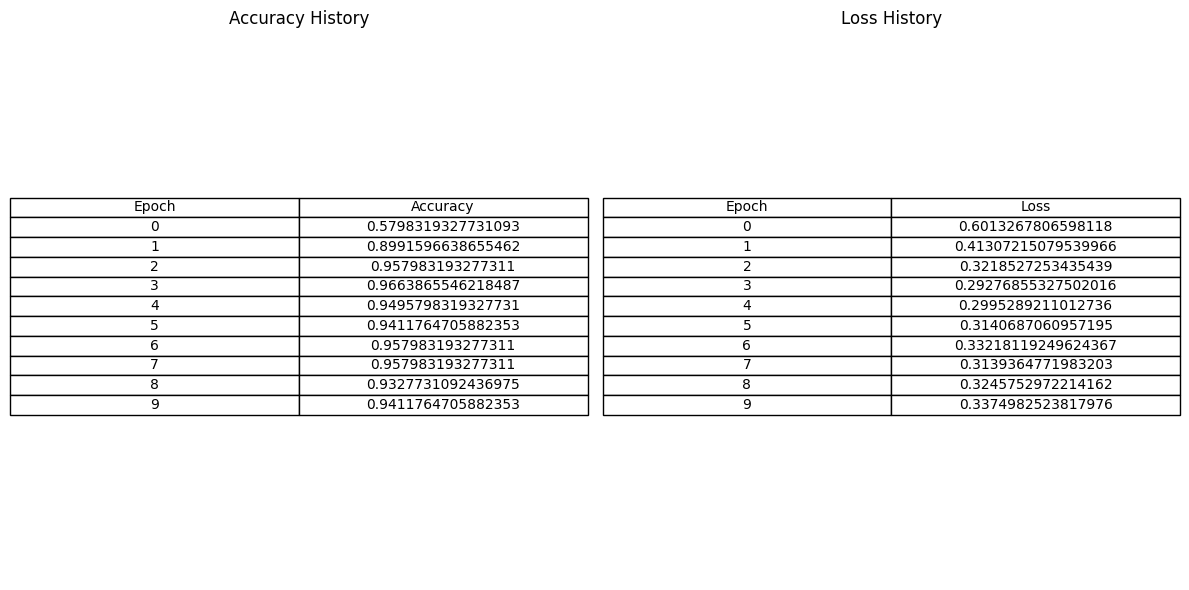

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 정확도 테이블
ax_acc = axes[0]
ax_acc.axis('off')
table_data_acc = [['Epoch', 'Accuracy']] + [[i, acc] for i, acc in enumerate(acc_history)] + [[i, acc] for i, acc in enumerate(eval_acc_history)]
ax_acc.table(cellText=table_data_acc, loc='center', cellLoc='center')
ax_acc.set_title("Accuracy History")

# 오차 테이블
ax_loss = axes[1]
ax_loss.axis('off')
table_data_loss = [['Epoch', 'Loss']] + [[i, loss] for i, loss in enumerate(loss_history)] + [[i, loss] for i, loss in enumerate(eval_loss_history)]
ax_loss.table(cellText=table_data_loss, loc='center', cellLoc='center')
ax_loss.set_title("Loss History")

plt.tight_layout()
plt.show()


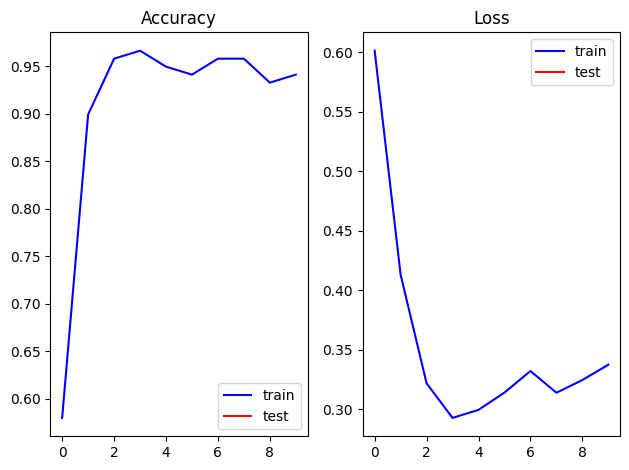

In [11]:
import matplotlib.pyplot as plt

plt.subplot(121)
plt.plot(range(len(acc_history)), acc_history, label="train", color="blue")
plt.plot(range(len(eval_acc_history)), eval_acc_history, label="test", color="red")
plt.legend()
plt.title("Accuracy")

plt.subplot(122)
plt.plot(range(len(loss_history)), loss_history, label="train", color="blue")
plt.plot(range(len(eval_loss_history)), eval_loss_history, label="test", color="red")
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.show()


In [12]:
from sklearn.manifold import TSNE

actual_train = []
deep_features_train = []
actual_test = []
deep_features_test = []

resnet18.train()

with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = resnet18(images)
        deep_features_train.append(features.cpu().numpy())
        actual_train.append(labels.cpu().numpy())

    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = resnet18(images)
        deep_features_test.append(features.cpu().numpy())
        actual_test.append(labels.cpu().numpy())

actual_train = np.concatenate(actual_train)
deep_features_train = np.concatenate(deep_features_train)
actual_test = np.concatenate(actual_test)
deep_features_test = np.concatenate(deep_features_test)

tsne = TSNE(n_components=2, random_state=0)
cluster_train = tsne.fit_transform(deep_features_train)
cluster_test = tsne.transform(deep_features_test)

plt.figure(figsize=(5, 5))
name = ['arctic fox', 'red fox']
plt.scatter(cluster_train[:, 0], cluster_train[:, 1], marker='.', label='Train')
plt.scatter(cluster_test[:, 0], cluster_test[:, 1], marker='.', label='Test')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


AttributeError: ignored